In [1]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import theano.tensor as tt

In [14]:
data = pd.read_csv('data/preprocessed/markers.csv')

# shapes and sizes
n_epochs = data['epoch_i'].max() + 1
n_raters = data['rater_i'].max() + 1
n_obs = data.shape[0]  # each spindle marker indexed by t

# static priors vars
trust_purcell = 0.1  # crank up to give more weight to purcell et al, 2017
purcell = np.array([0.3587, 0.6387, 0.0026, 0., 0., 0.]) + (1 - trust_purcell)
s_number_prior = purcell / purcell.sum()
max_s = len(s_number_prior) - 1
gss_spindle_testvals = [1., 5., 10., 15., 20.]


In [15]:
data

,Phase,Global Marker Index,annotatorID,s,d,e,epoch_i,rater_i,spindle_i,marker_per_r_i,conf,epoch_rater_i,t
0,phase1,R2908,295.0,20.98,1.07,22.05,0,0,0,2,0.99,0,0
1,phase1,R2909,295.0,23.48,1.43,24.91,0,0,1,2,0.99,0,1
2,phase1,R11229,45.0,1.99,0.44,2.43,0,1,0,5,0.50,1,2
3,phase1,R11230,45.0,7.92,0.27,8.19,0,1,1,5,0.50,1,3
4,phase1,R11231,45.0,6.12,0.49,6.61,0,1,2,5,0.50,1,4
5,phase1,R11232,45.0,21.07,0.41,21.48,0,1,3,5,0.50,1,5
6,phase1,R11233,45.0,23.59,0.41,24.00,0,1,4,5,0.50,1,6
7,phase1,R24211,165.0,1.98,0.48,2.46,0,2,0,1,0.99,2,7
8,phase1,R27097,473.0,1.69,0.81,2.50,0,3,0,6,0.25,3,8
9,phase1,R27098,473.0,6.18,0.51,6.69,0,3,1,6,0.25,3,9


In [35]:
with pm.Model() as model:

    # True s
    gss = pm.Uniform('gss', lower=0., upper=25., shape=(1,max_s),
                     testval=gss_spindle_testvals)
    gss_per_obs = gss[data['epoch_i'],:] #broadcast, 1 for each obs

    # The number of gss
    gss_prior = pm.Dirichlet('gss_prior', a=s_number_prior)
    z = pm.Categorical('z', p=gss_prior).reshape((1,1)) #change shape to fix theano reshape error
    z_per_obs = z[data['epoch_i']] #broadcast, 1 for each obs

    w_prior_possibilities = tt.tril(tt.ones((max_s + 1, max_s + 1)))
    w = pm.Categorical('w', p=w_prior_possibilities[z_per_obs[:,0],:], shape=n_obs)

    # --- Raters ability to detect gss --- #
    r_E = pm.Bound(pm.Normal, lower=0.)('r_E', mu=0.5, sd=0.5, shape=n_raters)
    r_E_per_obs = r_E[data['rater_i']]

    # --- Behaviour --- #
    contaminate_dist_s = pm.Uniform.dist(lower=0., upper=25., shape=n_obs)
    contaminate_dist_s.mean = 12.5
    possible_dists = [contaminate_dist_s]
    for i in range(0, 5):
        dist = pm.Normal.dist(mu=gss_per_obs[:, i], sd=r_E_per_obs)
        dist.mean = gss_spindle_testvals[i]
        possible_dists.append(dist)

    w_array = tt.extra_ops.to_one_hot(w, nb_class=max_s + 1)
    s = pm.Mixture('s', w=w_array,
                   comp_dists=possible_dists,
                   observed=data['s'])

  
    

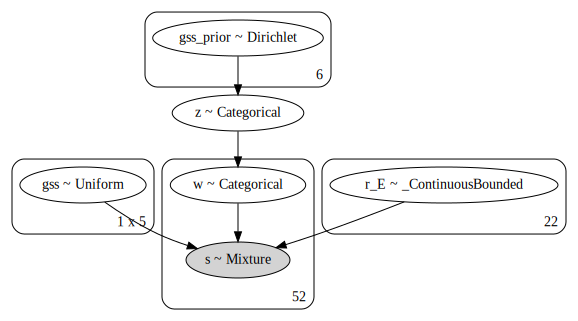

In [31]:
pm.model_to_graphviz(model)

In [36]:
with model:
    trace = pm.sample(tune=1000, nuts_kwargs={'target_accept': 0.9})

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [r_E, gss_prior, gss]
>CategoricalGibbsMetropolis: [w, z]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 3000/3000 [01:39<00:00, 27.65draws/s]
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


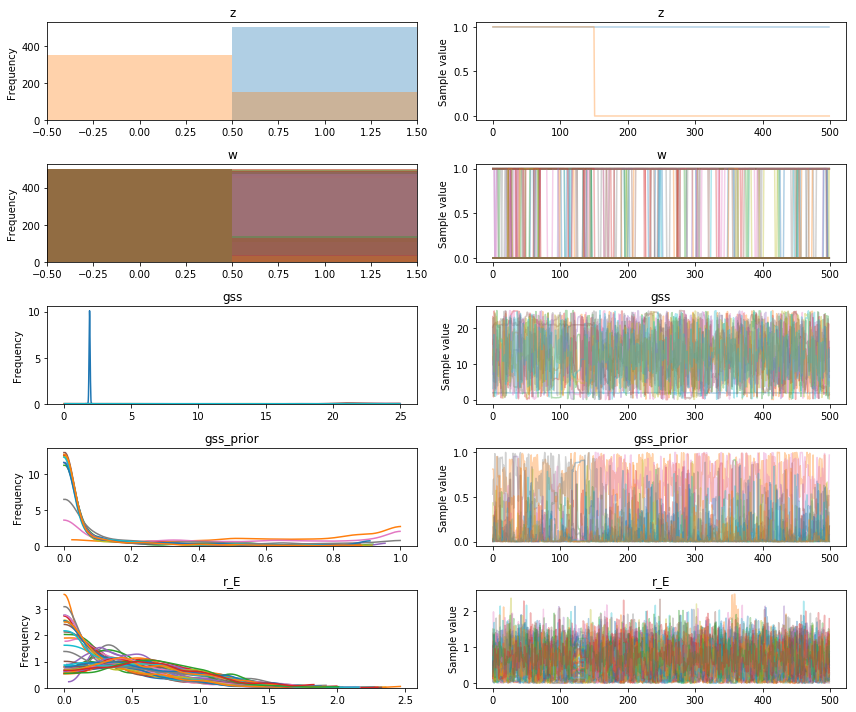

In [37]:
pm.traceplot(trace)
plt.show()